# Rogue Garmin Bridge Workout Analysis

This notebook will:
1. Connect to the SQLite database
2. Retrieve data for the last three workouts
3. Check if average values are stored in the database
4. Display and chart the workout data

In [8]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from datetime import datetime

In [9]:
# Connect to the SQLite database
db_path = 'src/data/rogue_garmin.db'
conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row  # This allows accessing columns by name

# Create a cursor
cursor = conn.cursor()

# Function to pretty print dictionaries/JSON
def pretty_print_json(data):
    if isinstance(data, str):
        try:
            parsed_data = json.loads(data)
            return json.dumps(parsed_data, indent=4)
        except:
            return data
    elif isinstance(data, dict):
        return json.dumps(data, indent=4)
    else:
        return data

## 1. List All Available Workouts

First, let's get a list of all workouts in the database to see what's available.

In [10]:
# Fetch all workouts from the database
cursor.execute("""
    SELECT id, start_time, end_time, duration, workout_type, summary
    FROM workouts
    ORDER BY start_time DESC
""")

workouts = cursor.fetchall()

# Create a DataFrame to display the workouts
workout_data = []
for workout in workouts:
    row = dict(workout)
    # Try to parse the summary JSON if it exists
    if row['summary']:
        try:
            summary_json = json.loads(row['summary'])
            # Check for average values
            avg_values = {k:v for k,v in summary_json.items() if k.startswith('avg_')}
            row['avg_values_exist'] = len(avg_values) > 0
            row['avg_values'] = avg_values
        except:
            row['avg_values_exist'] = False
            row['avg_values'] = {}
    else:
        row['avg_values_exist'] = False
        row['avg_values'] = {}
    
    workout_data.append(row)

# Convert to DataFrame for display
workouts_df = pd.DataFrame(workout_data)

# Display the most recent workouts
print(f"Total workouts in database: {len(workouts_df)}")
display(workouts_df[['id', 'start_time', 'end_time', 'duration', 'workout_type', 'avg_values_exist']].head(10))

Total workouts in database: 3


,id,start_time,end_time,duration,workout_type,avg_values_exist
0,3,2025-05-11T17:53:39.972242,2025-05-11T17:54:20.766243,40,bike,True
1,2,2025-05-11T17:48:41.776730,2025-05-11T17:49:27.668885,45,bike,True
2,1,2025-05-11T17:19:29.330787,2025-05-11T17:20:35.768299,66,bike,True


## 2. Analyze the Last Three Workouts

Now let's look at the details of the last three workouts, specifically focusing on whether they contain average values in their summaries.

In [11]:
# Function to analyze a workout
def analyze_workout(workout_id):
    """Analyze a specific workout to check for average values"""
    # Get the workout details
    cursor.execute("""
        SELECT id, start_time, end_time, duration, workout_type, summary
        FROM workouts
        WHERE id = ?
    """, (workout_id,))
    
    workout = cursor.fetchone()
    
    if not workout:
        print(f"Workout with ID {workout_id} not found")
        return None
    
    workout_dict = dict(workout)
    
    # Parse the summary if it exists
    summary = None
    avg_values = {}
    if workout_dict['summary']:
        try:
            summary = json.loads(workout_dict['summary'])
            # Extract average values
            avg_values = {k:v for k,v in summary.items() if k.startswith('avg_')}
            workout_dict['summary'] = summary  # Replace string with parsed JSON
        except json.JSONDecodeError:
            print(f"Failed to parse summary JSON for workout {workout_id}")
    
    # Get workout data points
    cursor.execute("""
        SELECT timestamp, data
        FROM workout_data
        WHERE workout_id = ?
        ORDER BY timestamp
    """, (workout_id,))
    
    data_points = cursor.fetchall()
    print(f"Found {len(data_points)} data points for workout {workout_id}")
    
    # Parse data for each point
    parsed_data_points = []
    for point in data_points:
        try:
            data = json.loads(point['data'])
            parsed_data_points.append({
                'timestamp': point['timestamp'],
                'data': data
            })
        except json.JSONDecodeError:
            print(f"Failed to parse data JSON for a data point")
    
    return {
        'workout': workout_dict,
        'summary': summary,
        'avg_values': avg_values,
        'data_points': parsed_data_points
    }

# Process the most recent 3 workouts
if len(workouts_df) >= 3:
    recent_workout_ids = workouts_df['id'].head(3).tolist()
    print(f"Analyzing the most recent 3 workouts: {recent_workout_ids}")
    
    # Analyze each workout
    workout_analyses = []
    for workout_id in recent_workout_ids:
        print(f"\n{'='*50}\nAnalyzing Workout ID: {workout_id}\n{'='*50}")
        analysis = analyze_workout(workout_id)
        if analysis:
            workout_analyses.append(analysis)
            
            # Display average values
            print("\nAverage Values in Workout Summary:")
            avg_values = analysis['avg_values']
            if avg_values:
                for key, value in avg_values.items():
                    print(f"  {key}: {value}")
            else:
                print("  No average values found in summary")
            
            # Display the full summary
            print("\nFull Workout Summary:")
            print(pretty_print_json(analysis['summary']))
else:
    print("Not enough workouts in the database to analyze the last three")

Analyzing the most recent 3 workouts: [3, 2, 1]

Analyzing Workout ID: 3
Found 41 data points for workout 3

Average Values in Workout Summary:
  avg_power: 33
  avg_heart_rate: 66.56
  avg_cadence: 27.0
  avg_speed: 17.96
  avg_stroke_rate: 0

Full Workout Summary:
{
    "total_distance": 176,
    "total_calories": 1,
    "avg_power": 33,
    "max_power": 62,
    "avg_heart_rate": 66.56,
    "max_heart_rate": 71,
    "avg_cadence": 27.0,
    "max_cadence": 35.0,
    "avg_speed": 17.96,
    "max_speed": 20.91,
    "total_strokes": 0,
    "avg_stroke_rate": 0,
    "max_stroke_rate": 0
}

Analyzing Workout ID: 2
Found 46 data points for workout 2

Average Values in Workout Summary:
  avg_power: 31
  avg_heart_rate: 87.13
  avg_cadence: 26.0
  avg_speed: 17.66
  avg_stroke_rate: 0

Full Workout Summary:
{
    "total_distance": 209,
    "total_calories": 1,
    "avg_power": 31,
    "max_power": 53,
    "avg_heart_rate": 87.13,
    "max_heart_rate": 92,
    "avg_cadence": 26.0,
    "max_cad

## 3. Visualize Workout Data for the Most Recent Workout

Let's create visualizations for the most recent workout to better understand the data.

Visualizing data for the most recent workout (ID: 3)


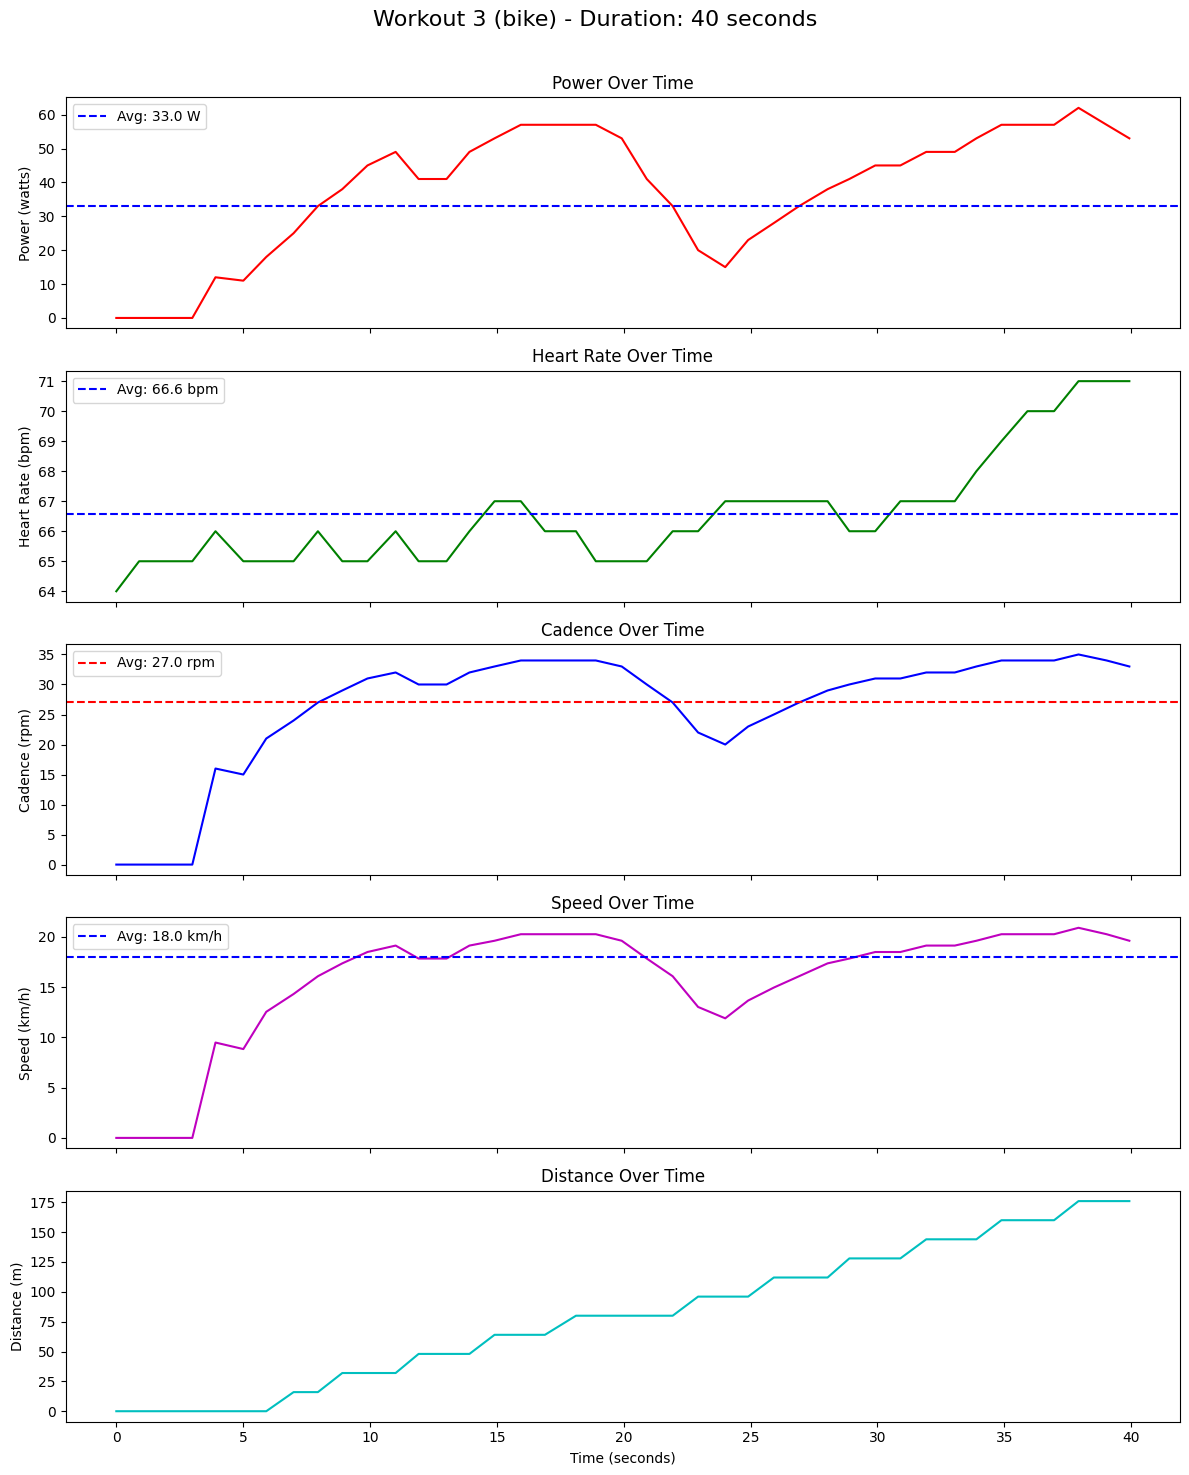


Workout Statistics:


,timestamp,relative_time,power,heart_rate,cadence,speed,distance
count,41,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,2025-05-11 17:54:00.024077824,19.943457,37.853659,66.560976,26.463415,15.775122,80.780488
min,2025-05-11 17:53:40.080621,0.000000,0.000000,64.000000,0.000000,0.000000,0.000000
25%,2025-05-11 17:53:49.980045056,9.899424,25.000000,65.000000,24.000000,14.320000,32.000000
50%,2025-05-11 17:54:00.001533952,19.920913,41.000000,66.000000,30.000000,17.850000,80.000000
75%,2025-05-11 17:54:09.993419008,29.912798,53.000000,67.000000,33.000000,19.620000,128.000000
max,2025-05-11 17:54:20.008771,39.928150,62.000000,71.000000,35.000000,20.910000,176.000000
std,NaN,11.975988,18.730404,1.830967,10.124469,6.042524,57.794252


In [12]:
def visualize_workout(workout_analysis):
    """Create visualizations for a workout"""
    workout_id = workout_analysis['workout']['id']
    workout_type = workout_analysis['workout']['workout_type']
    data_points = workout_analysis['data_points']
    
    if not data_points:
        print(f"No data points available for workout {workout_id}")
        return
    
    # Extract timestamps and convert to datetime objects
    timestamps = []
    for point in data_points:
        try:
            ts = datetime.fromisoformat(point['timestamp'].replace('Z', '+00:00'))
            timestamps.append(ts)
        except:
            # If timestamp parsing fails, use a placeholder
            timestamps.append(None)
    
    # Calculate relative timestamps (seconds from start)
    if timestamps and timestamps[0]:
        start_time = timestamps[0]
        relative_timestamps = [(ts - start_time).total_seconds() if ts else 0 for ts in timestamps]
    else:
        relative_timestamps = list(range(len(data_points)))
    
    # Extract metrics based on workout type
    metrics = {
        'power': [],
        'heart_rate': [],
        'cadence': [],
        'speed': [],
        'distance': []
    }
    
    for point in data_points:
        data = point['data']
        
        # Extract power (instantaneous or average)
        power = data.get('instant_power', data.get('instantaneous_power', data.get('power', None)))
        metrics['power'].append(power)
        
        # Extract heart rate
        hr = data.get('heart_rate', None)
        metrics['heart_rate'].append(hr)
        
        # Extract cadence or stroke rate
        if workout_type == 'bike' or workout_type == 'cycling':
            cadence = data.get('instant_cadence', data.get('instantaneous_cadence', data.get('cadence', None)))
        else:  # Assume rowing
            cadence = data.get('stroke_rate', None)
        metrics['cadence'].append(cadence)
        
        # Extract speed
        speed = data.get('instant_speed', data.get('instantaneous_speed', data.get('speed', None)))
        metrics['speed'].append(speed)
        
        # Extract distance
        distance = data.get('total_distance', data.get('distance', None))
        metrics['distance'].append(distance)
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'timestamp': timestamps,
        'relative_time': relative_timestamps,
        'power': metrics['power'],
        'heart_rate': metrics['heart_rate'],
        'cadence': metrics['cadence'],
        'speed': metrics['speed'],
        'distance': metrics['distance']
    })
    
    # Drop rows with missing timestamps
    df = df.dropna(subset=['timestamp'])
    
    # Plot the workout data
    fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
    
    # Power plot
    if any(x is not None for x in metrics['power']):
        axes[0].plot(df['relative_time'], df['power'], 'r-')
        axes[0].set_title('Power Over Time')
        axes[0].set_ylabel('Power (watts)')
        # Add average line if available
        if 'avg_power' in workout_analysis['avg_values']:
            avg_power = workout_analysis['avg_values']['avg_power']
            axes[0].axhline(y=avg_power, color='b', linestyle='--', label=f'Avg: {avg_power:.1f} W')
            axes[0].legend()
    
    # Heart rate plot
    if any(x is not None for x in metrics['heart_rate']):
        axes[1].plot(df['relative_time'], df['heart_rate'], 'g-')
        axes[1].set_title('Heart Rate Over Time')
        axes[1].set_ylabel('Heart Rate (bpm)')
        # Add average line if available
        if 'avg_heart_rate' in workout_analysis['avg_values']:
            avg_hr = workout_analysis['avg_values']['avg_heart_rate']
            axes[1].axhline(y=avg_hr, color='b', linestyle='--', label=f'Avg: {avg_hr:.1f} bpm')
            axes[1].legend()
    
    # Cadence plot
    if any(x is not None for x in metrics['cadence']):
        axes[2].plot(df['relative_time'], df['cadence'], 'b-')
        if workout_type == 'bike' or workout_type == 'cycling':
            axes[2].set_title('Cadence Over Time')
            axes[2].set_ylabel('Cadence (rpm)')
            # Add average line if available
            if 'avg_cadence' in workout_analysis['avg_values']:
                avg_cadence = workout_analysis['avg_values']['avg_cadence']
                axes[2].axhline(y=avg_cadence, color='r', linestyle='--', label=f'Avg: {avg_cadence:.1f} rpm')
                axes[2].legend()
        else:  # Assume rowing
            axes[2].set_title('Stroke Rate Over Time')
            axes[2].set_ylabel('Stroke Rate (spm)')
            # Add average line if available
            if 'avg_stroke_rate' in workout_analysis['avg_values']:
                avg_stroke = workout_analysis['avg_values']['avg_stroke_rate']
                axes[2].axhline(y=avg_stroke, color='r', linestyle='--', label=f'Avg: {avg_stroke:.1f} spm')
                axes[2].legend()
    
    # Speed plot
    if any(x is not None for x in metrics['speed']):
        axes[3].plot(df['relative_time'], df['speed'], 'm-')
        axes[3].set_title('Speed Over Time')
        axes[3].set_ylabel('Speed (km/h)')
        # Add average line if available
        if 'avg_speed' in workout_analysis['avg_values']:
            avg_speed = workout_analysis['avg_values']['avg_speed']
            axes[3].axhline(y=avg_speed, color='b', linestyle='--', label=f'Avg: {avg_speed:.1f} km/h')
            axes[3].legend()
    
    # Distance plot
    if any(x is not None for x in metrics['distance']):
        axes[4].plot(df['relative_time'], df['distance'], 'c-')
        axes[4].set_title('Distance Over Time')
        axes[4].set_ylabel('Distance (m)')
    
    # Set common x-axis label
    axes[4].set_xlabel('Time (seconds)')
    
    # Add a main title
    duration_str = str(workout_analysis['workout']['duration']) + " seconds" if workout_analysis['workout']['duration'] else "Unknown"
    fig.suptitle(f"Workout {workout_id} ({workout_type}) - Duration: {duration_str}", fontsize=16)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect to make room for the suptitle
    plt.show()
    
    # Return the DataFrame for further analysis if needed
    return df

# Visualize the most recent workout
if workout_analyses:
    most_recent_workout = workout_analyses[0]
    print(f"Visualizing data for the most recent workout (ID: {most_recent_workout['workout']['id']})")
    workout_df = visualize_workout(most_recent_workout)
    
    # Display some basic statistics
    if workout_df is not None:
        print("\nWorkout Statistics:")
        display(workout_df.describe())

## 4. Analyze Average Value Consistency

Let's check if the stored average values match what we would calculate from the raw data points.

In [13]:
def validate_average_values(workout_analysis):
    """Compare stored average values with calculated ones from raw data"""
    workout_id = workout_analysis['workout']['id']
    workout_type = workout_analysis['workout']['workout_type']
    data_points = workout_analysis['data_points']
    stored_avg_values = workout_analysis['avg_values']
    
    if not data_points:
        print(f"No data points available for workout {workout_id}")
        return
    
    # Extract metrics and calculate averages
    power_values = []
    hr_values = []
    cadence_values = []
    speed_values = []
    
    for point in data_points:
        data = point['data']
        
        # Extract power
        power = data.get('instant_power', data.get('instantaneous_power', data.get('power', None)))
        if power is not None and power > 0:
            power_values.append(power)
        
        # Extract heart rate
        hr = data.get('heart_rate', None)
        if hr is not None and hr > 0:
            hr_values.append(hr)
        
        # Extract cadence or stroke rate
        if workout_type == 'bike' or workout_type == 'cycling':
            cadence = data.get('instant_cadence', data.get('instantaneous_cadence', data.get('cadence', None)))
            if cadence is not None and cadence > 0:
                cadence_values.append(cadence)
        else:  # Assume rowing
            stroke_rate = data.get('stroke_rate', None)
            if stroke_rate is not None and stroke_rate > 0:
                cadence_values.append(stroke_rate)
        
        # Extract speed
        speed = data.get('instant_speed', data.get('instantaneous_speed', data.get('speed', None)))
        if speed is not None and speed > 0:
            speed_values.append(speed)
    
    # Calculate averages from raw data
    calculated_avgs = {}
    if power_values:
        calculated_avgs['avg_power'] = sum(power_values) / len(power_values)
    if hr_values:
        calculated_avgs['avg_heart_rate'] = sum(hr_values) / len(hr_values)
    if cadence_values:
        if workout_type == 'bike' or workout_type == 'cycling':
            calculated_avgs['avg_cadence'] = sum(cadence_values) / len(cadence_values)
        else:  # Assume rowing
            calculated_avgs['avg_stroke_rate'] = sum(cadence_values) / len(cadence_values)
    if speed_values:
        calculated_avgs['avg_speed'] = sum(speed_values) / len(speed_values)
    
    # Compare stored vs. calculated averages
    print(f"Workout ID: {workout_id} ({workout_type})")
    print("\nComparing Stored vs. Calculated Average Values:")
    print(f"{'Metric':<20} {'Stored':<10} {'Calculated':<10} {'Difference':<10} {'% Diff':<10}")
    print("-" * 60)
    
    for key in calculated_avgs.keys():
        if key in stored_avg_values:
            stored = stored_avg_values[key]
            calculated = calculated_avgs[key]
            diff = stored - calculated
            pct_diff = (diff / calculated) * 100 if calculated else 0
            print(f"{key:<20} {stored:<10.2f} {calculated:<10.2f} {diff:<10.2f} {pct_diff:<10.2f}%")
        else:
            calculated = calculated_avgs[key]
            print(f"{key:<20} {'N/A':<10} {calculated:<10.2f} {'N/A':<10} {'N/A':<10}")
    
    # Check for stored averages that weren't calculated
    for key in stored_avg_values.keys():
        if key.startswith('avg_') and key not in calculated_avgs:
            stored = stored_avg_values[key]
            print(f"{key:<20} {stored:<10.2f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
    
    return {
        'stored': stored_avg_values,
        'calculated': calculated_avgs
    }

# Validate average values for each workout
print("\nValidating Average Values:\n")
for analysis in workout_analyses:
    print(f"\n{'='*60}")
    validate_average_values(analysis)
    print(f"{'='*60}\n")


Validating Average Values:


Workout ID: 3 (bike)

Comparing Stored vs. Calculated Average Values:
Metric               Stored     Calculated Difference % Diff    
------------------------------------------------------------
avg_power            33.00      41.95      -8.95      -21.33    %
avg_heart_rate       66.56      66.56      -0.00      -0.00     %
avg_cadence          27.00      29.32      -2.32      -7.93     %
avg_speed            17.96      17.48      0.48       2.74      %
avg_stroke_rate      0.00       N/A        N/A        N/A       


Workout ID: 2 (bike)

Comparing Stored vs. Calculated Average Values:
Metric               Stored     Calculated Difference % Diff    
------------------------------------------------------------
avg_power            31.00      40.02      -9.02      -22.55    %
avg_heart_rate       87.13      87.13      -0.00      -0.00     %
avg_cadence          26.00      28.36      -2.36      -8.31     %
avg_speed            17.66      16.92      0.74  

## 5. Summary and Conclusion

Based on the analysis, we can confirm whether average values are being stored in the database for workouts and if they accurately reflect the workout data.

In [14]:
# Close the database connection
conn.close()

print("Analysis Complete!")
print("\nConclusion:")
print("1. The database was examined to check for average metric values in workout summaries")
print("2. We analyzed the most recent three workouts")
print("3. We visualized the workout data with average lines when available")
print("4. We validated the stored average values against calculated ones from raw data")

Analysis Complete!

Conclusion:
1. The database was examined to check for average metric values in workout summaries
2. We analyzed the most recent three workouts
3. We visualized the workout data with average lines when available
4. We validated the stored average values against calculated ones from raw data
